# Подготовка данных для загрузки в модель.

In [ ]:
import os
import cv2
import torch
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
from multiprocessing import freeze_support
import matplotlib.pyplot as plt
import numpy as np
import pytorch_lightning as pl
from torch.optim import lr_scheduler
import segmentation_models_pytorch as smp


class SegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = sorted(os.listdir(image_dir))  # List of image filenames

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]  # Use self.images, not self.img_names
        img_path = os.path.join(self.image_dir, img_name)
        mask_path = os.path.join(self.mask_dir, img_name)  # Assumes mask has same name

        # Check if image file exists
        if not os.path.exists(img_path):
            raise FileNotFoundError(f"Image not found at: {img_path}")

        # Load image
        image = cv2.imread(img_path)
        if image is None:
            raise ValueError(f"Failed to load image at: {img_path}")

        # Convert to RGB
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Check if mask file exists
        if not os.path.exists(mask_path):
            raise FileNotFoundError(f"Mask not found at: {mask_path}")

        # Load mask
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        if mask is None:
            raise ValueError(f"Failed to load mask at: {mask_path}")

        # Apply transformations if provided
        if self.transform is not None:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        return image, mask

# Аугментация
train_transform = A.Compose([
    A.Resize(256, 256),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])

val_transform = A.Compose([
    A.Resize(256, 256),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    A.ToTensorV2()
])

In [ ]:
n_cpu = os.cpu_count()
train_dataset = SegmentationDataset(
    image_dir=r'D:\URFU\VKR\Ind_pract\dissert\data\train\images',
    mask_dir=r'D:\URFU\VKR\Ind_pract\dissert\data\train\masks',
    transform=train_transform
)

valid_dataset = SegmentationDataset(
    image_dir=r'D:\URFU\VKR\Ind_pract\dissert\data\val\images',
    mask_dir=r'D:\URFU\VKR\Ind_pract\dissert\data\val\masks',
    transform=val_transform
)

test_dataset = SegmentationDataset(
    image_dir=r'D:\URFU\VKR\Ind_pract\dissert\data\test\images',
    mask_dir=r'D:\URFU\VKR\Ind_pract\dissert\data\test\masks',
    transform=val_transform
)

train_loader = DataLoader(train_dataset,
                                batch_size=4,
                                shuffle=True
                                )
valid_loader = DataLoader(valid_dataset,
                                batch_size=4
                                )
test_loader = DataLoader(test_dataset,
                                batch_size=4
                                )

images, masks = next(iter(train_loader))
print("Размерность изображений:", images.shape)
print("Размерность масок:", masks.shape)
print("Тип изображений:", images.dtype)
print("Тип масок:", masks.dtype)
print("Классы:", masks.unique())


Размерность изображений: torch.Size([4, 3, 256, 256])
Размерность масок: torch.Size([4, 256, 256])
Тип изображений: torch.float32
Тип масок: torch.uint8
Классы: tensor([0, 1], dtype=torch.uint8)


# Пример данных 

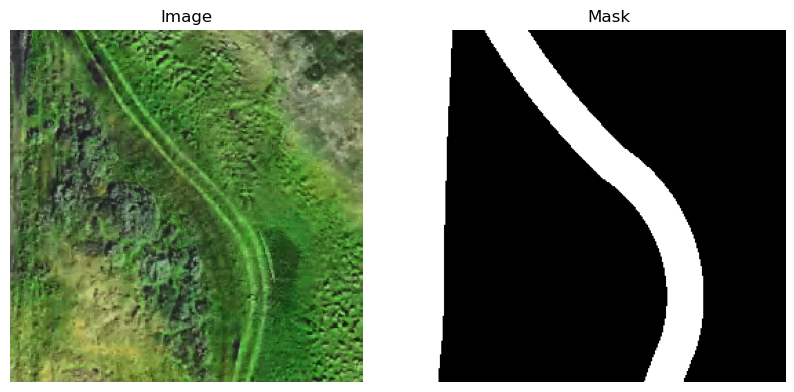

In [ ]:
import numpy as np

# Функция для денормализации изображения
def denormalize(image, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)):
    image = image.clone()  
    for i in range(3):  
        image[i] = image[i] * std[i] + mean[i]
    return image

# Получение одного примера из датасета
sample = train_dataset[30]
image, mask = sample  

# Подготовка изображения для визуализации
image = denormalize(image) 
image = image.permute(1, 2, 0)  
image = image.numpy() 
image = np.clip(image, 0, 1)  

# Подготовка маски для визуализации
mask = mask.squeeze()  
mask = mask.numpy() 

# Визуализация
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Image")
plt.imshow(image)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Mask")
plt.imshow(mask, cmap='gray') 
plt.axis('off')

plt.show()

# Model U-net

In [ ]:
import pytorch_lightning as pl
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from pytorch_lightning.callbacks import Callback, ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
from torchmetrics import JaccardIndex, Precision, Recall, F1Score
from torchmetrics.segmentation import DiceScore, GeneralizedDiceScore, MeanIoU
from pytorch_lightning import LightningModule



# Блок двойной свёртки: Conv -> BN -> ReLU -> Conv -> BN -> ReLU
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class UNet(LightningModule):
    def __init__(self, in_channels=3, out_channels=1, features=[32, 64, 128, 256], 
                 learning_rate=1e-3, pretrained_weights_path=None):
        super().__init__()
        self.save_hyperparameters()
        self.learning_rate = learning_rate
        
        # Инициализация метрик
        self.train_jaccard = JaccardIndex(task="binary", num_classes=2)
        self.train_precision = Precision(task="binary", num_classes=2)
        self.train_recall = Recall(task="binary", num_classes=2)
        self.train_f1 = F1Score(task="binary", num_classes=2)
        self.train_dice_score = DiceScore(average='micro', num_classes=2)
        self.train_generalized_dice = GeneralizedDiceScore(num_classes=2, per_class=False, weight_type="square")
        self.train_mean_iou = MeanIoU(num_classes=2)
        
        self.val_jaccard = JaccardIndex(task="binary", num_classes=2)
        self.val_precision = Precision(task="binary", num_classes=2)
        self.val_recall = Recall(task="binary", num_classes=2)
        self.val_f1 = F1Score(task="binary", num_classes=2)
        self.val_dice_score = DiceScore(average='micro', num_classes=2)
        self.val_generalized_dice = GeneralizedDiceScore(num_classes=2, per_class=False, weight_type="square")
        self.val_mean_iou = MeanIoU(num_classes=2)
        
        self.test_jaccard = JaccardIndex(task="binary", num_classes=2)
        self.test_precision = Precision(task="binary", num_classes=2)
        self.test_recall = Recall(task="binary", num_classes=2)
        self.test_f1 = F1Score(task="binary", num_classes=2)
        self.test_dice_score = DiceScore(average='micro', num_classes=2)
        self.test_generalized_dice = GeneralizedDiceScore(num_classes=2, per_class=False, weight_type="square")
        self.test_mean_iou = MeanIoU(num_classes=2)
        
        # Остальная часть модели
        self.encoder1 = DoubleConv(in_channels, features[0])
        self.encoder2 = DoubleConv(features[0], features[1])
        self.encoder3 = DoubleConv(features[1], features[2])
        self.encoder4 = DoubleConv(features[2], features[3])
        
        self.bottleneck = DoubleConv(features[3], features[3]*2)
        
        self.upconv4 = nn.ConvTranspose2d(features[3]*2, features[3], kernel_size=2, stride=2)
        self.decoder4 = DoubleConv(features[3]*2, features[3])
        
        self.upconv3 = nn.ConvTranspose2d(features[3], features[2], kernel_size=2, stride=2)
        self.decoder3 = DoubleConv(features[2]*2, features[2])
        
        self.upconv2 = nn.ConvTranspose2d(features[2], features[1], kernel_size=2, stride=2)
        self.decoder2 = DoubleConv(features[1]*2, features[1])
        
        self.upconv1 = nn.ConvTranspose2d(features[1], features[0], kernel_size=2, stride=2)
        self.decoder1 = DoubleConv(features[0]*2, features[0])
        
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        if pretrained_weights_path:
            self.load_pretrained(pretrained_weights_path)

    def load_pretrained(self, path):
        try:
            checkpoint = torch.load(path, map_location=self.device)
            if 'state_dict' in checkpoint:
                self.load_state_dict(checkpoint['state_dict'], strict=False)
            else:
                self.load_state_dict(checkpoint, strict=False)
            self.print(f"Loaded pretrained weights from {path}")
        except Exception as e:
            self.print(f"Error loading weights: {e}")

    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool(enc1))
        enc3 = self.encoder3(self.pool(enc2))
        enc4 = self.encoder4(self.pool(enc3))
        
        bottleneck = self.bottleneck(self.pool(enc4))
        
        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.decoder4(dec4)
        
        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.decoder3(dec3)
        
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.decoder2(dec2)
        
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.decoder1(dec1)
        
        return torch.sigmoid(self.final_conv(dec1))

    def dice_loss(self, pred, target, smooth=1e-6):
        pred_flat = pred.view(-1)
        target_flat = target.view(-1)
        intersection = (pred_flat * target_flat).sum()
        dice = (2. * intersection + smooth) / (pred_flat.sum() + target_flat.sum() + smooth)
        return 1 - dice

    def step(self, batch, batch_idx, stage):
        x, y = batch
        y_pred = self(x)
        loss = self.dice_loss(y_pred, y)
        
        y_pred_class = (y_pred > 0.5).squeeze(1).int()
        y_int = y.squeeze(1).int()
        
        metrics = {
            'jaccard': getattr(self, f"{stage}_jaccard"),
            'precision': getattr(self, f"{stage}_precision"),
            'recall': getattr(self, f"{stage}_recall"),
            'f1': getattr(self, f"{stage}_f1"),
            'dice_score': getattr(self, f"{stage}_dice_score"),
            'generalized_dice': getattr(self, f"{stage}_generalized_dice"),
            'mean_iou': getattr(self, f"{stage}_mean_iou")
        }
        
        for metric in metrics.values():
            metric.update(y_pred_class, y_int)
        
        return loss, metrics

    def training_step(self, batch, batch_idx):
        loss, _ = self.step(batch, batch_idx, 'train')
        self.log('train_loss', loss, prog_bar=True, on_step=False, on_epoch=True)
        return loss

    def on_train_epoch_start(self):
        self.reset_metrics('train')

    def validation_step(self, batch, batch_idx):
        loss, _ = self.step(batch, batch_idx, 'val')
        self.log('val_loss', loss, prog_bar=True, on_step=False, on_epoch=True)
        return loss

    def on_validation_epoch_start(self):
        self.reset_metrics('val')

    def test_step(self, batch, batch_idx):
        loss, _ = self.step(batch, batch_idx, 'test')
        self.log('test_loss', loss, prog_bar=True, on_step=False, on_epoch=True)
        return loss

    def on_test_epoch_start(self):
        self.reset_metrics('test')

    def reset_metrics(self, stage):
        for metric in [getattr(self, f"{stage}_{m}") for m in 
                      ['jaccard', 'precision', 'recall', 'f1', 
                       'dice_score', 'generalized_dice', 'mean_iou']]:
            metric.reset()

    def on_training_epoch_end(self):
        self.log_metrics('train')

    def on_validation_epoch_end(self):
        self.log_metrics('val')

    def on_test_epoch_end(self):
        self.log_metrics('test')

    def log_metrics(self, stage):
        for metric_name in ['jaccard', 'precision', 'recall', 'f1', 
                           'dice_score', 'generalized_dice', 'mean_iou']:
            metric = getattr(self, f"{stage}_{metric_name}")
            self.log(f"{stage}_{metric_name}", metric.compute(), on_epoch=True)
            metric.reset()

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.learning_rate)



# Обучение модели U-net

In [ ]:

# Инициализация модели
model = UNet(
    in_channels=3,
    out_channels=1,
    learning_rate=1e-3,
    pretrained_weights_path=None  # Укажите путь к весам, если нужно
)

# Настройка логгера TensorBoard
logger = TensorBoardLogger(save_dir="../logs/", name="Unet_segmentation")


# Настройка callback для сохранения лучшей модели
checkpoint_callback = ModelCheckpoint(
    monitor="val_loss",  
    dirpath="../data/checkpoints/", 
    filename="unet-{epoch:02d}-{val_loss:.2f}",  
    save_top_k=1, 
    mode="min"  
)

# Настройка тренера с callback
trainer = pl.Trainer(
    max_epochs=76,
    accelerator='gpu' if torch.cuda.is_available() else 'cpu',
    devices=1,
    logger=logger,
    callbacks=[checkpoint_callback]
)

# Дообучение модели

checkpoint_path = "../data/checkpoints/unet-epoch=71-val_loss=0.39.ckpt"

trainer.fit(model,train_loader, valid_loader, ckpt_path=checkpoint_path)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\ProgramData\anaconda3\envs\vkr\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:654: Checkpoint directory D:\URFU\VKR\Ind_pract\dissert\data\checkpoints exists and is not empty.
Restoring states from the checkpoint path at ../data/checkpoints/unet-epoch=71-val_loss=0.39.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                   | Type                 | Params | Mode 
-------------------------------------------------------------------------
0  | train_jaccard          | BinaryJaccardIndex   | 0      | train
1  | train_precision        | BinaryPrecision      | 0      | train
2  | train_recall           | BinaryRecall         | 0      | train
3  | train_f1               | BinaryF1Score        | 0      | train
4  | train_dice_score       | DiceScore            | 0      | train
5  | train_generalized_dice | GeneralizedDiceScore | 0      | t

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

c:\ProgramData\anaconda3\envs\vkr\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


c:\ProgramData\anaconda3\envs\vkr\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Epoch 75: 100%|██████████| 1088/1088 [02:02<00:00,  8.87it/s, v_num=7, val_loss=0.400, train_loss=0.285]

`Trainer.fit` stopped: `max_epochs=76` reached.


Epoch 75: 100%|██████████| 1088/1088 [02:02<00:00,  8.87it/s, v_num=7, val_loss=0.400, train_loss=0.285]


# Тестирование модели U-net

In [ ]:
# Тестирование
trainer.test(model, test_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\ProgramData\anaconda3\envs\vkr\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 234/234 [00:11<00:00, 20.19it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_dice_score      │    0.48831820487976074    │
│          test_f1          │    0.6212679147720337     │
│   test_generalized_dice   │    0.3295390009880066     │
│       test_jaccard        │    0.45060819387435913    │
│         test_loss         │    0.4112953543663025     │
│       test_mean_iou       │    0.4164298474788666     │
│      test_precision       │    0.7017659544944763     │
│        test_recall        │    0.5573370456695557     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.4112953543663025,
  'test_jaccard': 0.45060819387435913,
  'test_precision': 0.7017659544944763,
  'test_recall': 0.5573370456695557,
  'test_f1': 0.6212679147720337,
  'test_dice_score': 0.48831820487976074,
  'test_generalized_dice': 0.3295390009880066,
  'test_mean_iou': 0.4164298474788666}]

# Инференс

In [ ]:
# Загрузка модели из чекпоинта
model = UNet.load_from_checkpoint(r"D:\URFU\VKR\Ind_pract\dissert\data\checkpoints\unet-epoch=71-val_loss=0.39.ckpt")
model.eval()

UNet(
  (train_jaccard): BinaryJaccardIndex()
  (train_precision): BinaryPrecision()
  (train_recall): BinaryRecall()
  (train_f1): BinaryF1Score()
  (train_dice_score): DiceScore()
  (train_generalized_dice): GeneralizedDiceScore()
  (train_mean_iou): MeanIoU()
  (val_jaccard): BinaryJaccardIndex()
  (val_precision): BinaryPrecision()
  (val_recall): BinaryRecall()
  (val_f1): BinaryF1Score()
  (val_dice_score): DiceScore()
  (val_generalized_dice): GeneralizedDiceScore()
  (val_mean_iou): MeanIoU()
  (test_jaccard): BinaryJaccardIndex()
  (test_precision): BinaryPrecision()
  (test_recall): BinaryRecall()
  (test_f1): BinaryF1Score()
  (test_dice_score): DiceScore()
  (test_generalized_dice): GeneralizedDiceScore()
  (test_mean_iou): MeanIoU()
  (encoder1): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inpl

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\ProgramData\anaconda3\envs\vkr\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00,  8.86it/s] 
Saved mask: ../output\83-5-066-496_009_011_mask.png


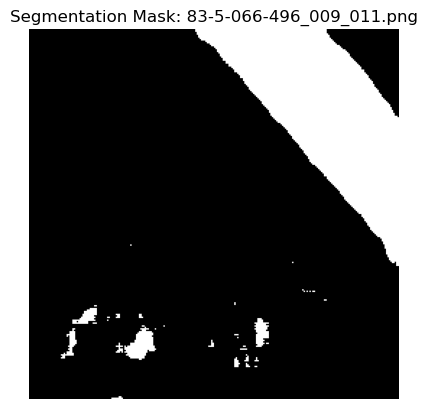

Saved mask: ../output\83-5-066-496_038_023_mask.png


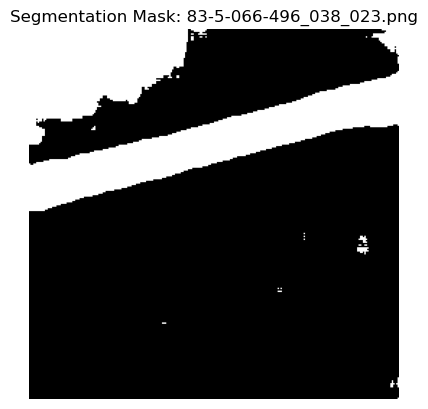

In [ ]:
import glob
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import torchvision.transforms as transforms
import torch
import os
import numpy as np
import matplotlib.pyplot as plt

input_path = r"D:\URFU\VKR\Ind_pract\dissert\input"
files = glob.glob(os.path.join(input_path, "*"))
files = [file for file in files if os.path.isfile(file)]

class InferenceDataset(Dataset):
    def __init__(self, image_paths):
        self.image_paths = image_paths  # Store paths here
        self.transform = transforms.Compose([
            transforms.Resize([256, 256]),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB")
        image = self.transform(image)
        return image 

# Загрузчик данных
test_dataset = InferenceDataset(files)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
image_paths = test_dataset.image_paths 

# Инференс
predictions = trainer.predict(model, dataloaders=test_loader)

# Выгрузка
output_dir = "../output/unet"
os.makedirs(output_dir, exist_ok=True)

# Обработка файлов 
for i, pred_batch in enumerate(predictions): # type: ignore
    
    pred = pred_batch[0]
    
    # Преобразование в маску
    prob = torch.sigmoid(pred)
    mask = (prob > 0.5).float().squeeze().cpu().numpy() 
    
    # Формирование путей выгрузки 
    path = image_paths[i]
    base_name = os.path.splitext(os.path.basename(path))[0]
    output_path = os.path.join(output_dir, f"{base_name}_mask.png")
    
    # Сохранение
    Image.fromarray((mask * 255).astype(np.uint8)).save(output_path)
    print(f"Saved mask: {output_path}")

    plt.imshow(mask, cmap="gray")
    plt.title(f"Segmentation Mask: {os.path.basename(path)}")
    plt.axis("off")
    plt.show()